In [3]:
!wget  -O 'train_sem2.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [4]:
import pandas as pd
import numpy as np
data = pd.read_csv("train_sem2.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data = data.drop(columns = ['Id'])
y = data['SalePrice']
X = data.drop(columns = ['SalePrice'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 10, test_size = 0.3)

<Axes: xlabel='SalePrice', ylabel='Count'>

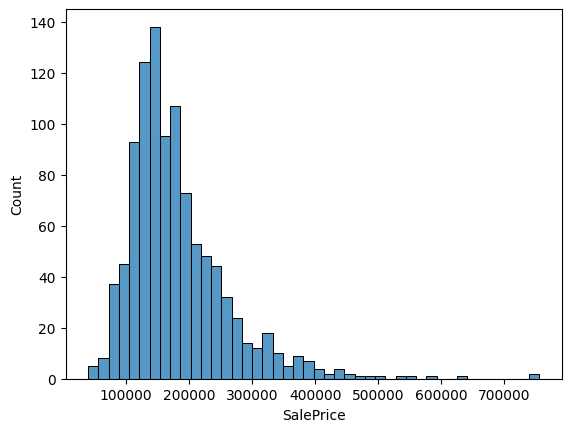

In [6]:
import seaborn as sns
sns.histplot(y_train)

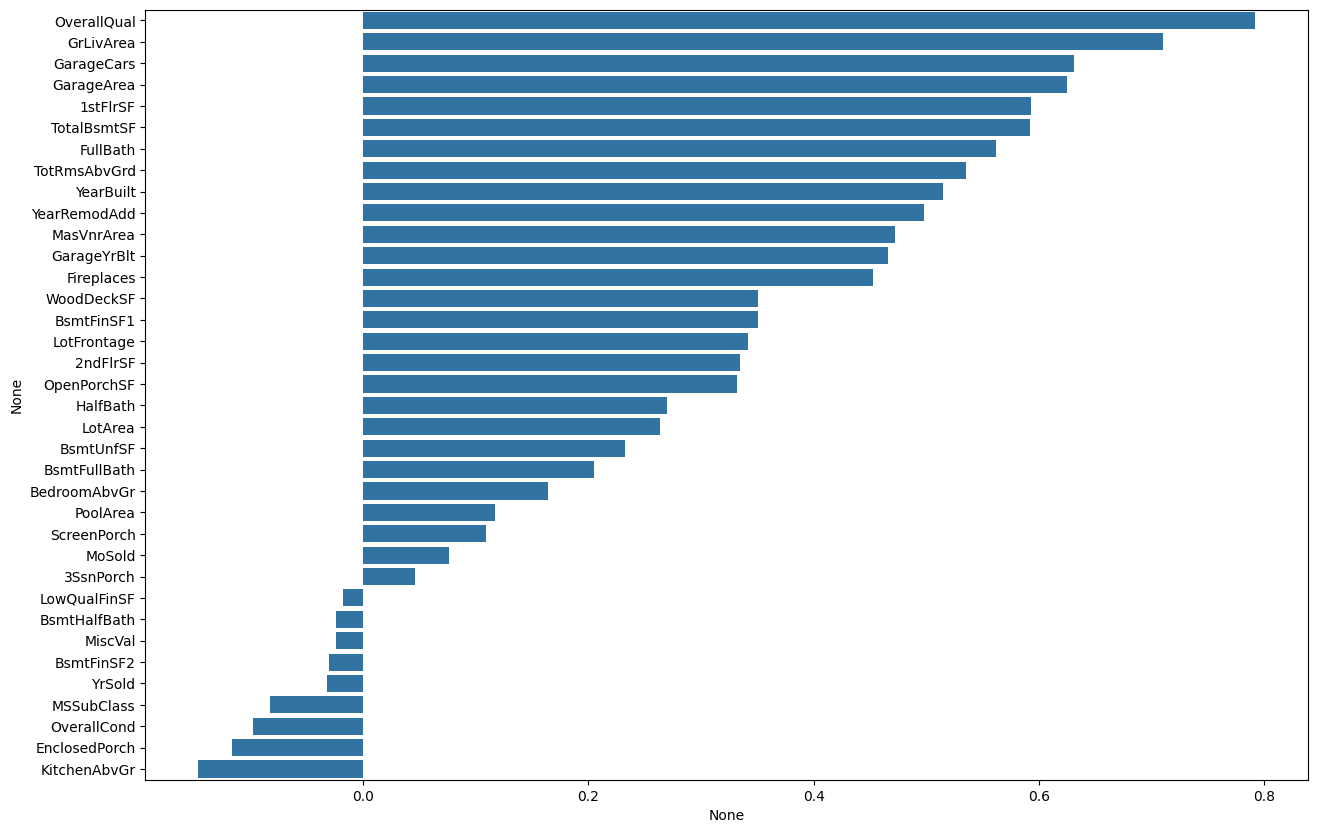

In [7]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(x=correlations, y=correlations.index)
plot.figure.set_size_inches(15, 10)

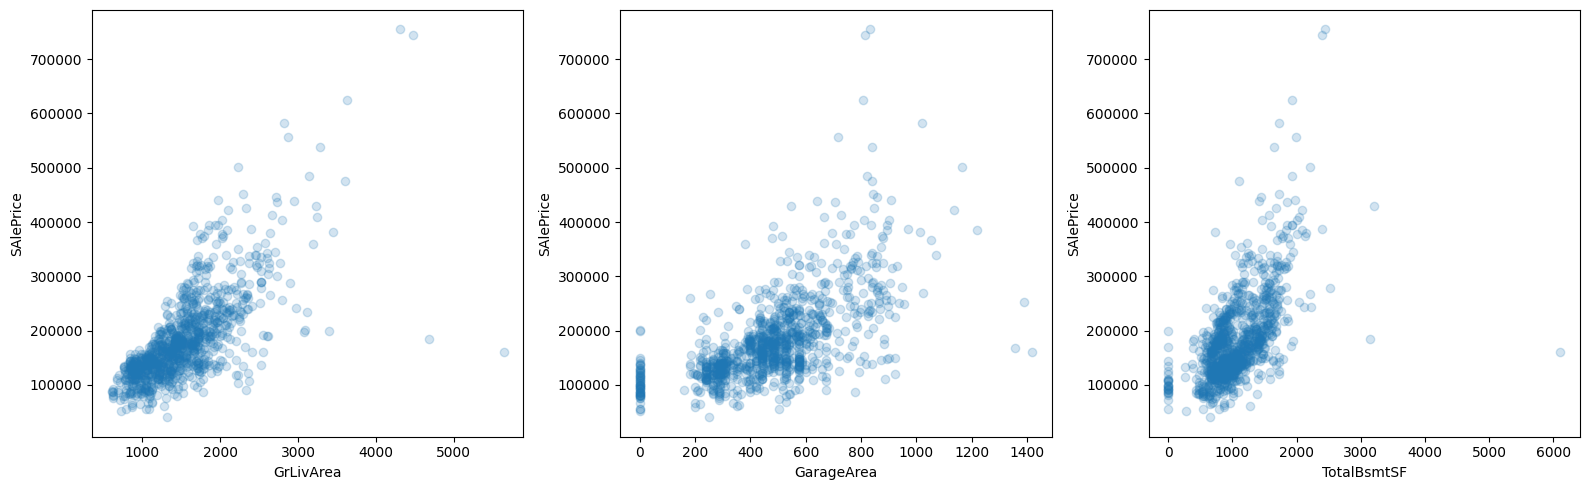

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (16, 5), ncols = 3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
  axs[i].scatter(X_train[feature], y_train, alpha = 0.2)
  axs[i].set_xlabel(feature)
  axs[i].set_ylabel('SAlePrice')
plt.tight_layout()

In [9]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])
test_error = (mean_squared_error(y_test, y_pred)) ** 0.5
train_error = (mean_squared_error(y_train_pred, y_train)) ** 0.5
print(f"Test MSE = {test_error}")
print(f"Train error: {train_error}")

Test MSE = 32085.768137655672
Train error: 35631.31309355794


In [10]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV MSE = 40156.3616


In [11]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV RMSE = 40156.3616


In [14]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % mean_squared_error(y_test, best_constant * np.ones(y_test.shape)))
print("Train RMSE with best constant = %.4f" % mean_squared_error(y_train, best_constant * np.ones(y_train.shape)))

Test RMSE with best constant = 5873156015.4490
Train RMSE with best constant = 6494525534.9763


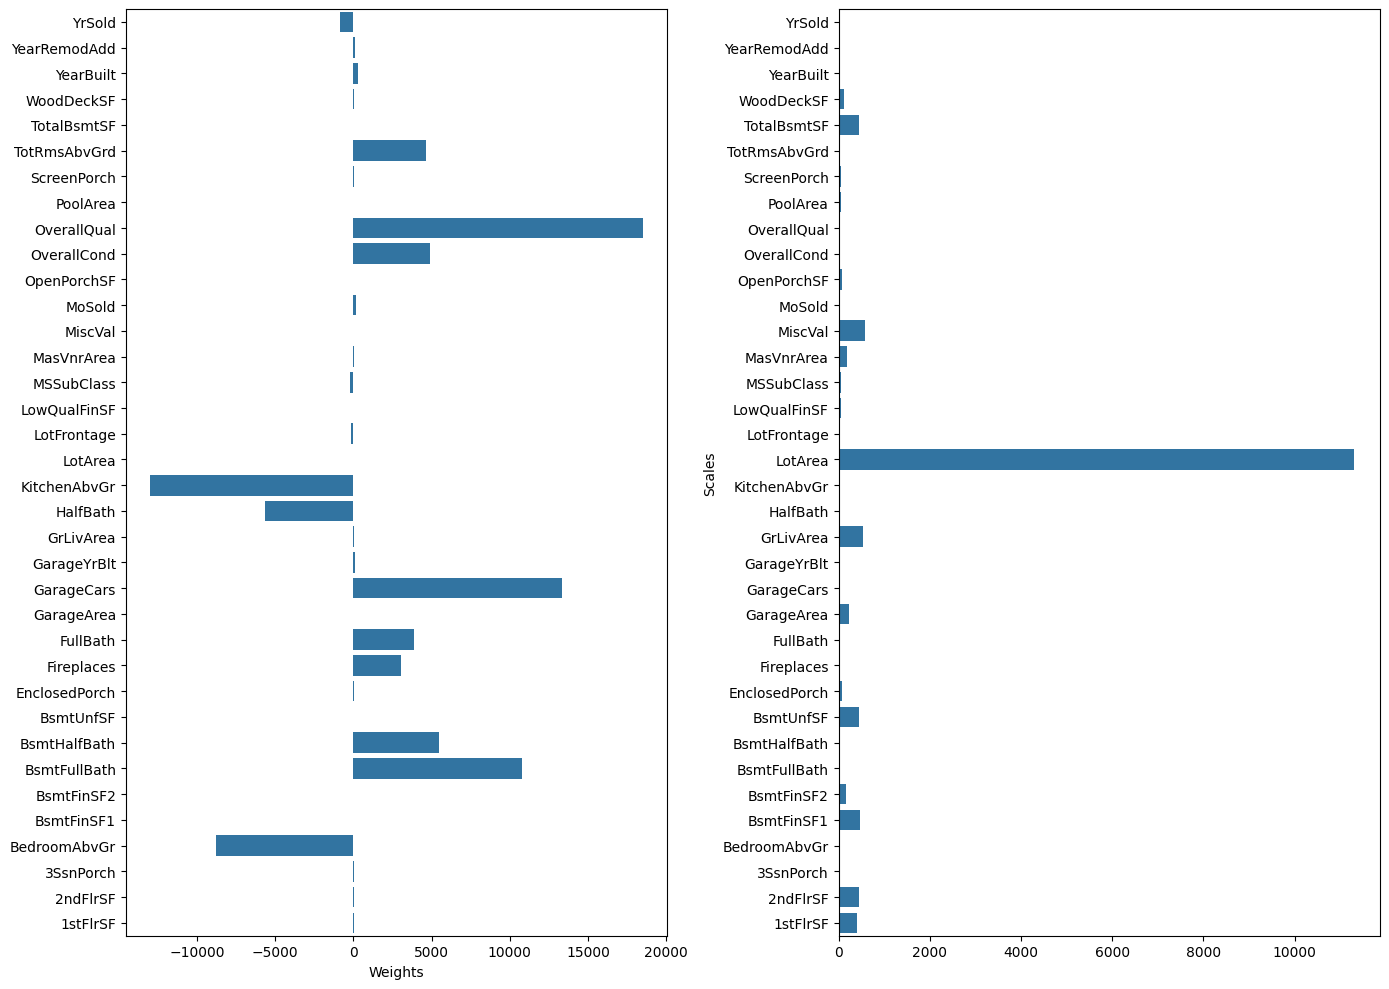

In [18]:
def show_weights(features, weights, scales):
  fig, axs = plt.subplots(figsize = (14, 10), ncols = 2)
  sorted_weights = sorted(zip(features, weights, scales), reverse = True)
  features = [x[0] for x in sorted_weights]
  weights = [x[1] for x in sorted_weights]
  scales = [x[2] for x in sorted_weights]
  sns.barplot(x = weights, y = features, ax = axs[0])
  axs[0].set_xlabel("Weights")
  sns.barplot(x = scales, y = features, ax = axs[1])
  axs[1].set_ylabel("Scales")
  plt.tight_layout()
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

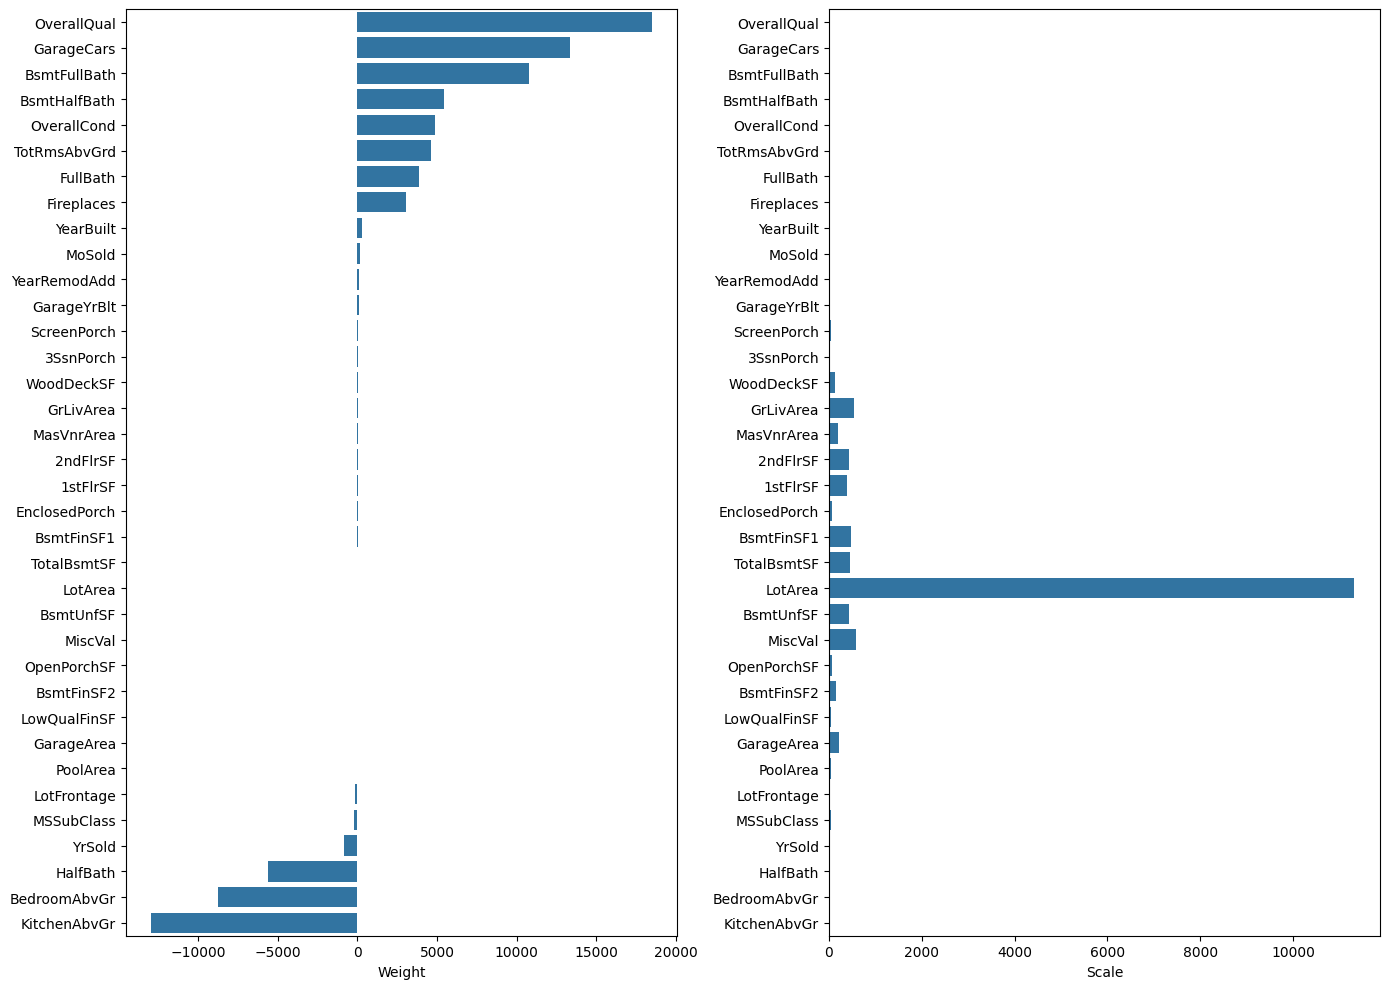

In [19]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mean = round((mean_squared_error(y_pred, y_test)) ** 0.5, 4)
print(mean)

32085.315


Best alpha = 297.6351


Text(0, 0.5, 'CV score')

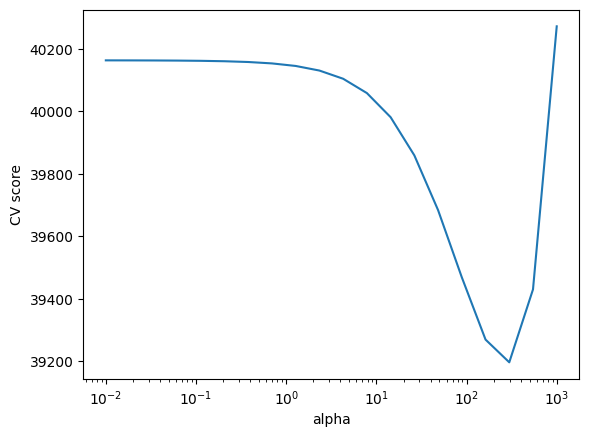

In [25]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [28]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
mean = (round(mean_squared_error(y_test, y_pred), 4) ** 0.5)
print(mean)

31703.359018768027


In [29]:
categorical = list(X_train.dtypes[X_train.dtypes == 'object'].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [30]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
320,RL,Pave,NotGiven,Reg,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,New,Partial
806,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1375,RL,Pave,NotGiven,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,New,Partial
1358,FV,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1331,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % (mean_squared_error(y_test, y_pred) ** 0.5))

Test RMSE = 26071.0846


In [33]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 293)


In [36]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % (mean_squared_error(y_test, y_pred))**0.5)

RMSE = 26446.6016


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1165605883.192627, tolerance: 663740509.6745819
  model = cd_fast.sparse_enet_coordinate_descent(


In [40]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print(f"Lasso zeros: {lasso_zeros}")
print(f"Ridge_zeros: {ridge_zeros}")

Lasso zeros: 31
Ridge_zeros: 0


Best alpha = 263.6651


Text(0, 0.5, 'CV score')

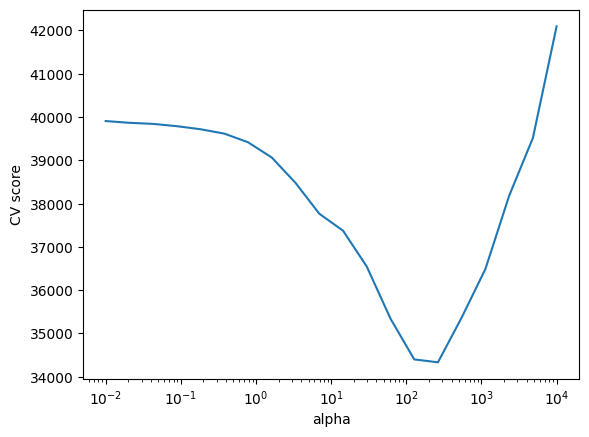

In [41]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [42]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline([
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f"MSE = %.4f" % (mean_squared_error(y_test, y_pred)** 0.5))

MSE = 25645.3918


In [44]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print(lasso_zeros)

217


<ipython-input-45-780c6929b39a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error)


<Axes: xlabel='SalePrice', ylabel='Density'>

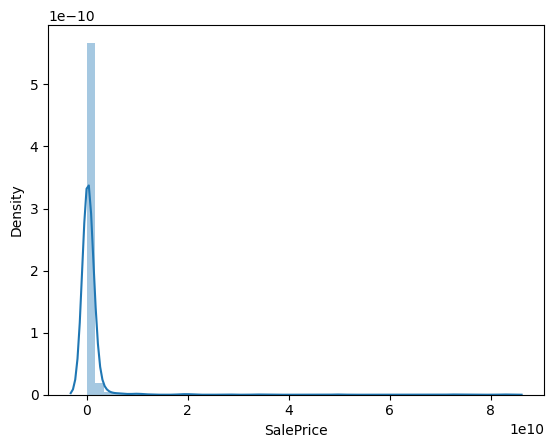

In [45]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

In [47]:
mask = (error < np.quantile(error, 0.95))
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % (mean_squared_error(y_test, y_pred)**0.5))

Test RMSE = 24963.5948


<ipython-input-48-8ddb86e3799b>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  error = (y_train[mask] - model.predict(X_train[mask])) ** 2
<ipython-input-48-8ddb86e3799b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error)


<Axes: xlabel='SalePrice', ylabel='Density'>

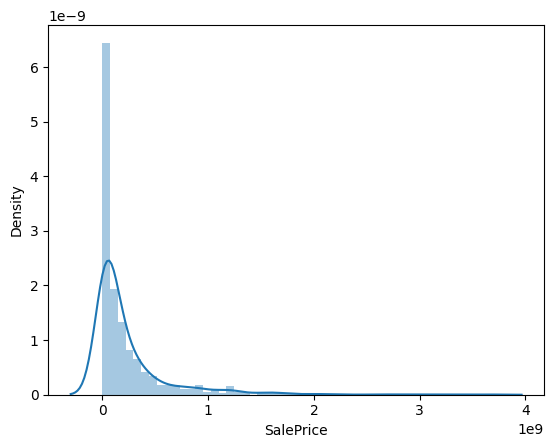

In [48]:
X_train = X_train[mask]
y_train = y_train[mask]
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error)

In [49]:
#Data-preparing for Linear-model

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred)**0.5)

Test RMSE = 23428.7760


Text(0, 0.5, 'SalePrice')

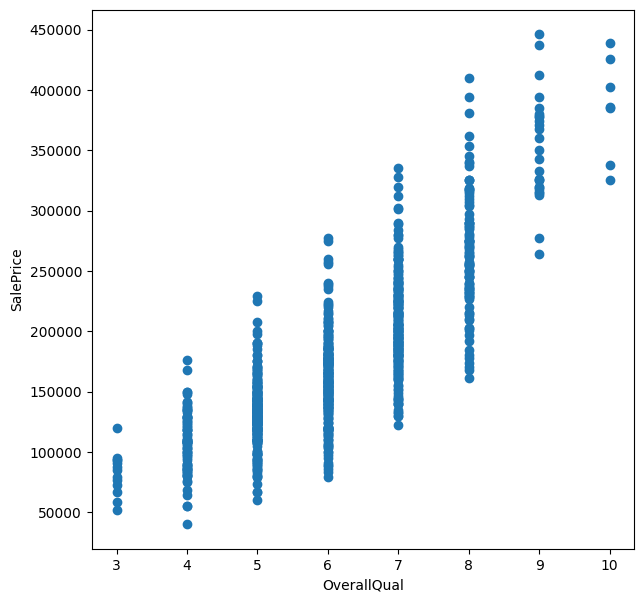

In [50]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train.OverallQual, y_train)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

In [52]:
threshold = 5
mask = (X_train.OverallQual <= threshold)
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]
column_transformer1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer1),
    ('regression', Ridge())
])

column_transformer2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer2),
    ('regression', Ridge())
])



model1 = pipeline1.fit(X_train_1, y_train_1)
model2 = pipeline2.fit(X_train_2, y_train_2)

y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
mask_test = (X_test.OverallQual <= threshold)
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

print(f"Test MSE: %.4f" % mean_squared_error(y_test, y_pred)**0.5)

Test MSE: 22594.5221
